# Player analysis - Premier League 2017/2018

In this file we will analyze how the different players in Everton FC performed in different types of metrics. This will allow us to find the weakeast links in the team as well where the biggest potential for new players could play a part. We hope to figure out what player/players that should be transfered out and make room for a new player/players. 

In [413]:
# Imports
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager, add_image
# add image
from urllib.request import urlopen
from PIL import Image

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [414]:
# Get Data
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "events", 'events_England.json') 
with open(path) as f: 
    data = json.load(f) 
train = pd.DataFrame(data) 

train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

In [415]:
# Turnovers
def turnovers(df):
    dribble_forward = df.loc[df["subEventName"] == "Ground attacking duel"]
    lost_dribble_forward = dribble_forward.loc[dribble_forward.apply(lambda x:{'id':701} in x.tags, axis = 1)]
    ldf = lost_dribble_forward.groupby(["playerId"]).eventId.count().reset_index()
    ldf.rename(columns = {'eventId':'lost_dribble_forward'}, inplace=True)
    
    passes = df.loc[df["eventName"] == "Pass"]
    lost_pass = passes.loc[passes.apply(lambda x:{'id':1802} in x.tags, axis = 1)]
    lp = lost_pass.groupby(["playerId"]).eventId.count().reset_index()
    lp.rename(columns = {'eventId':'lost_pass'}, inplace=True)

    turnovers_made = ldf.merge(lp, how = "outer", on = ["playerId"])

    return turnovers_made

turnover = turnovers(train)

In [416]:
# Clearances 
def clearance(df):
    clearance = df.loc[df["subEventName"] == "Clearance"]
    clearing_player = clearance.groupby(["playerId"]).eventId.count().reset_index()
    clearing_player.rename(columns = {'eventId':'clearances'}, inplace=True)

    return clearing_player

clear = clearance(train)

In [417]:
# Interceptions
def interception(df):
    opp_pass = df.loc[df["eventName"] == "Pass"]
    interception = opp_pass.loc[opp_pass.apply(lambda x:{'id':1401} in x.tags, axis = 1)]
    intercepting_player = interception.groupby(["playerId"]).eventId.count().reset_index()
    intercepting_player.rename(columns = {'eventId':'interceptions'}, inplace=True)

    return intercepting_player

intercept = interception(train)

In [418]:
# Duels Won
def defensiveDuelsWon(df):
    loose_duels = df.loc[df["subEventName"] == "Ground loose ball duel"]
    won_loose_duels = loose_duels.loc[loose_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wld_player = won_loose_duels.groupby(["playerId"]).eventId.count().reset_index()
    wld_player.rename(columns = {'eventId':'loose_duels_won'}, inplace=True)
    
    def_ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = def_ground_duels.loc[def_ground_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wgd_player = won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'def_ground_duels_won'}, inplace=True)

    air_duels = df.loc[df["subEventName"].isin(["Air duel"])]
    won_air_duels = air_duels.loc[air_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wad_player = won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)
    
    duels_won = wgd_player.merge(wld_player, how = "outer", on = ["playerId"]).merge(wad_player, how = "outer", on = ["playerId"])

    return duels_won

duels = defensiveDuelsWon(train)

In [419]:
# Turnover calculations
def calc(values, percentiles):
    lost_pass = values[-1]
    values.pop()
    lost_dribble = values[-1]
    values.pop()
    turnovers = lost_pass + lost_dribble # how many turnovers per 90 min

    lost_pass_perc = percentiles[-1]
    percentiles.pop()
    lost_dribble_perc = percentiles[-1]
    percentiles.pop()

    values_new = values.append(turnovers)
    percentiles_new = percentiles.append(135-turnovers*10)

    return percentiles_new, values_new

In [420]:
# Minutes per game calculations 
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "minutes_played", 'minutes_played_per_game_England.json') 
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

In [421]:
# Summary
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(duels, how = "left", on = ["playerId"]).merge(intercept, how = "left", on = ["playerId"]).merge(clear, how = "left", on = ["playerId"]).merge(turnover, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

In [422]:
# Print out all the shortNames and roles of the players that also have a currentTeamId of 1623
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "players.json")
with open(path) as f:
    everton = json.load(f)
everton = pd.DataFrame(everton)
everton = everton.loc[everton["currentTeamId"] == 1623]
everton = everton[["shortName", "wyId", "role"]]  # Include 'role' column
everton.rename(columns = {'wyId':'playerId'}, inplace=True)
everton = everton.merge(summary, how = "left", on = ["playerId"])
everton = everton.fillna(0)

# Print just the defenders
defenders = everton.loc[everton.apply(lambda x: x.role["name"] == "Defender", axis = 1)]
defenders 

,shortName,playerId,role,minutesPlayed,def_ground_duels_won,loose_duels_won,air_duels_won,interceptions,clearances,lost_dribble_forward,lost_pass
2,Y. Mina,256634,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,K. Zouma,25854,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",3022.0,54.0,42.0,122.0,87.0,148.0,13.0,168.0
9,P. Jagielka,8245,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2164.0,39.0,35.0,79.0,76.0,102.0,4.0,176.0
10,L. Baines,8239,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",1999.0,13.0,22.0,14.0,30.0,35.0,10.0,154.0
11,S. Coleman,8240,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",1079.0,22.0,9.0,16.0,27.0,12.0,11.0,105.0
14,M. Keane,7919,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",2676.0,53.0,56.0,167.0,83.0,108.0,1.0,180.0
16,J. Kenny,286825,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",1671.0,23.0,23.0,41.0,36.0,57.0,11.0,158.0
19,M. Holgate,355937,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",1239.0,18.0,21.0,44.0,28.0,52.0,6.0,119.0


In [423]:
# Positions
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', 'players.json')
with open(path) as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Defender", axis = 1)]
forwards.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])

In [424]:
# Per 90
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

## Players


### K. Zouma

In [425]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "K. Zouma"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  70.68333333333334


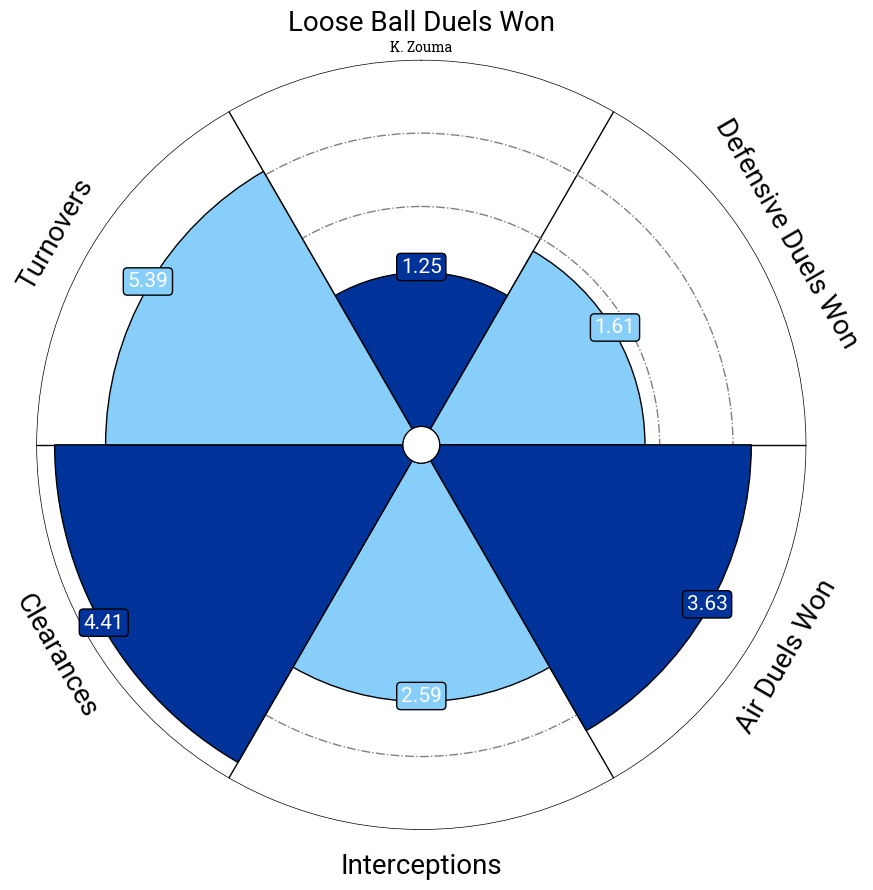

In [426]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "K. Zouma" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### P. Jagielka	

In [427]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "P. Jagielka"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  74.18333333333334


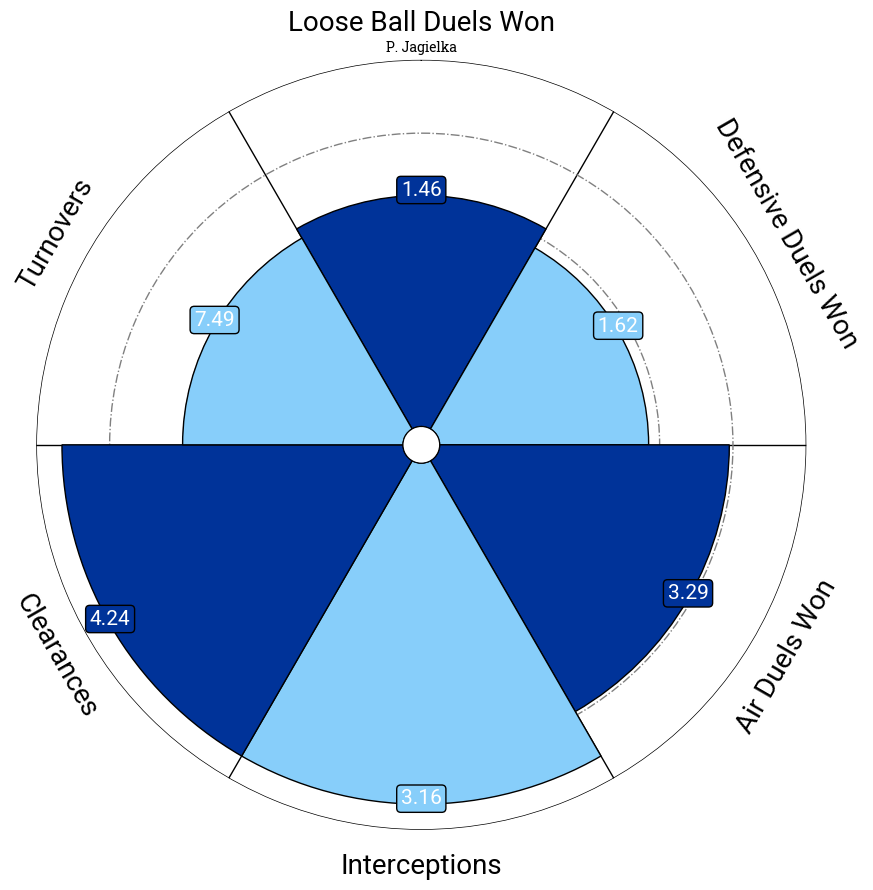

In [428]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "P. Jagielka" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### L. Baines

In [429]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "L. Baines"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  17.866666666666667


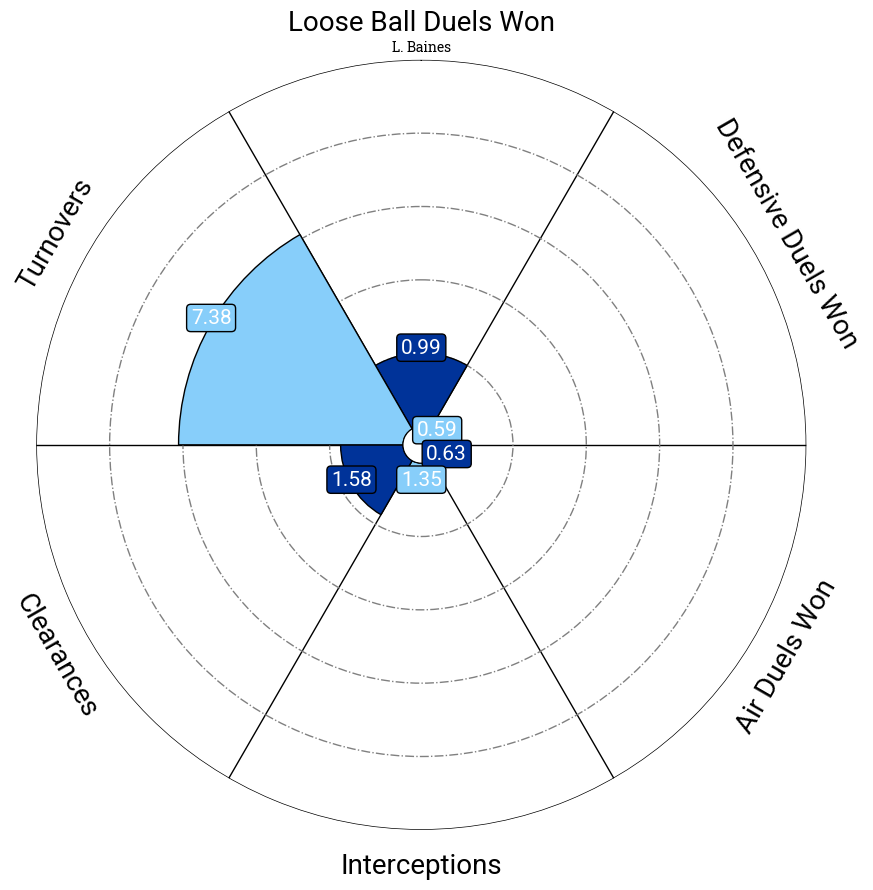

In [430]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "L. Baines" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### S. Coleman

In [431]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "S. Coleman"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  31.7


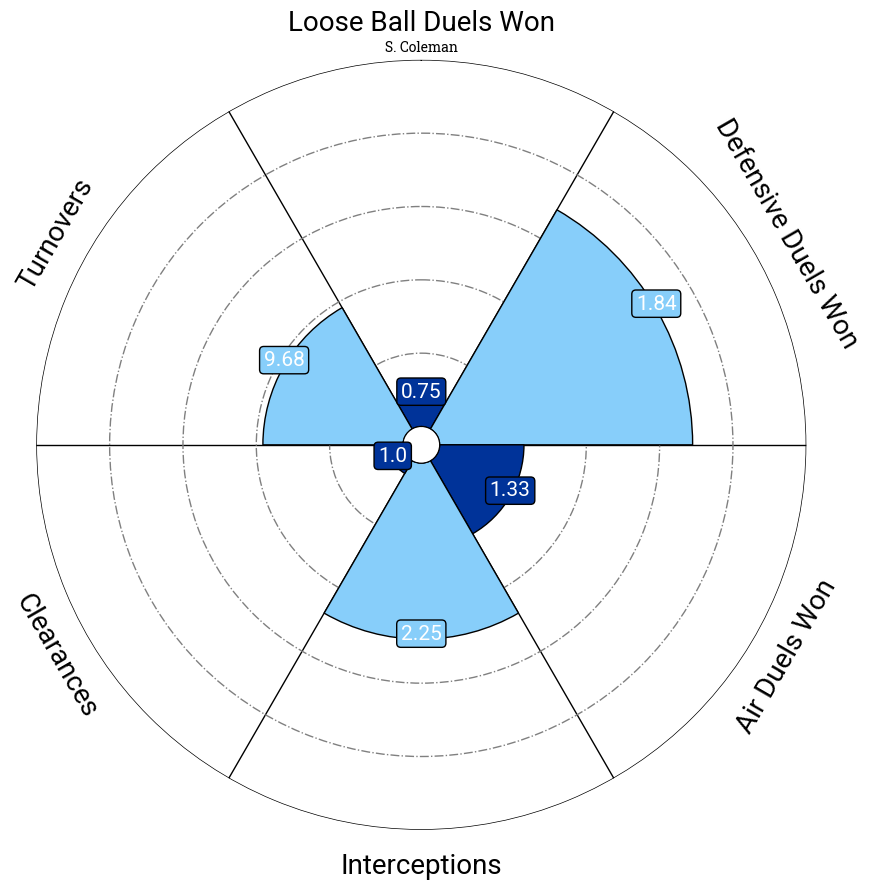

In [432]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "S. Coleman" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### M. Keane

In [433]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "M. Keane"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  82.2


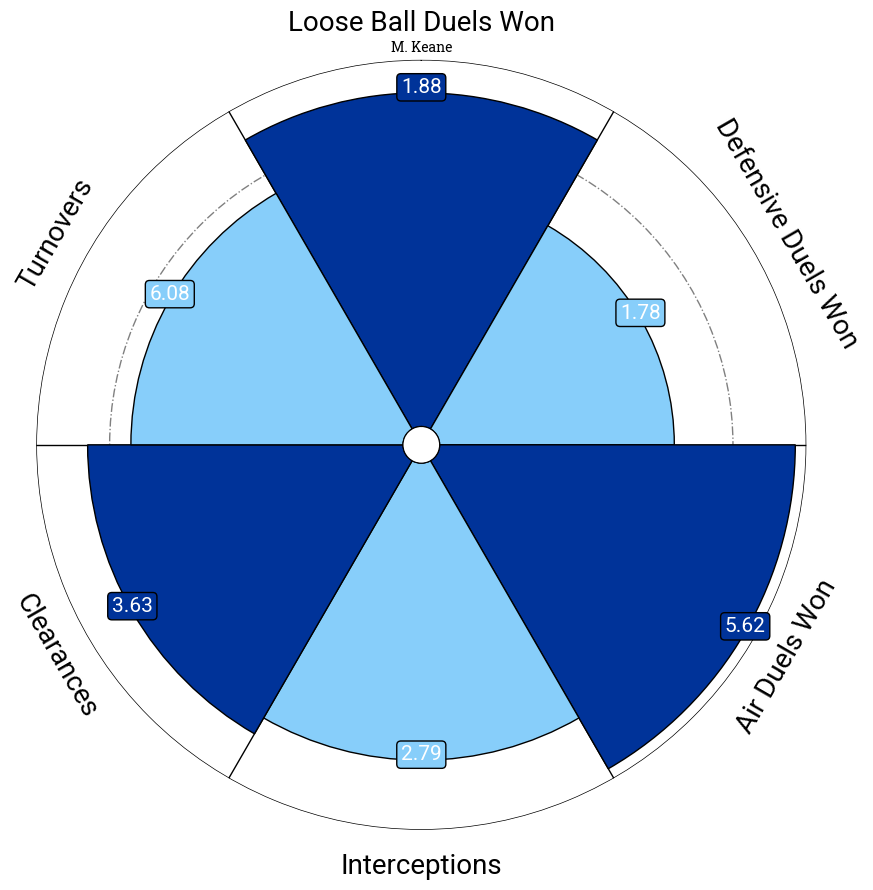

In [434]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "M. Keane" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### J. Kenny

In [435]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "J. Kenny"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  43.833333333333336


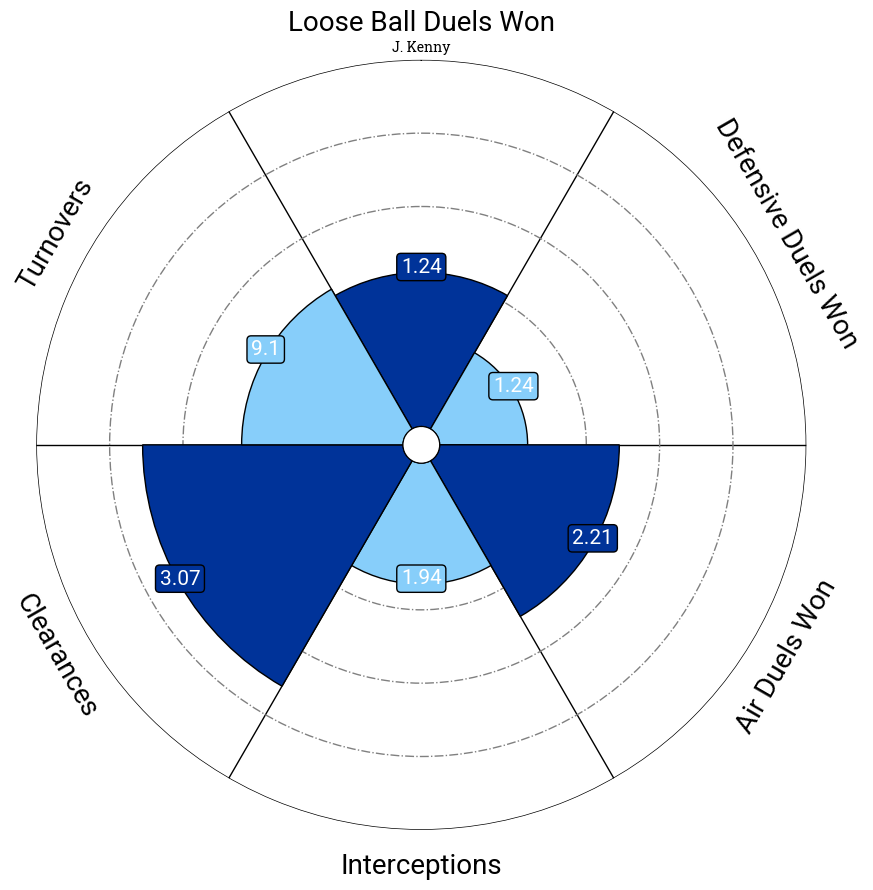

In [436]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "J. Kenny" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

### M. Holgate

In [437]:
#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == "M. Holgate"]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  57.86666666666667


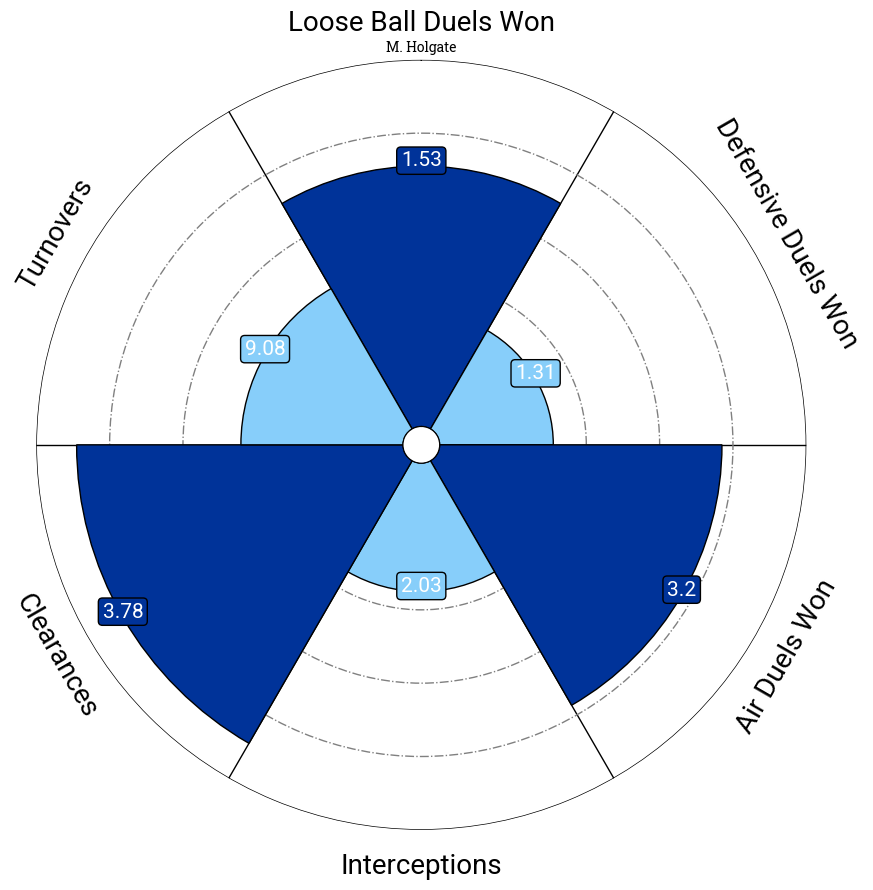

In [438]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"] + ["#003399"] + ["lightskyblue"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

player_name = "M. Holgate" 

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))

## Conclusion

From the plots of the defensive players of the Everton squad, it is possible to see a big difference in performance in the chosen metrics.
K. Zouma, P. Jagielka and M. Keane has performed much better than the other players. The players who performed the worst was J. Kenny, S. Coleman and L. Baines. The later three players should all be considered for transfering out from the club.

# Scouting

Let's look for new players that could replace the worst players in our team. We are looking for right- and left-backs.
One metric that is especially important for defender is their ability to intercept the ball. So let's look at the best interceptors.

One important thing to note is that we are going to look at players from France, since often they have players with bigger potential than the PL and you can get them for a cheaper price tag. 

In [441]:
# Data
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "events", 'events_France.json') 
with open(path) as f:
    data = json.load(f) 
train = pd.DataFrame(data) 

train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

In [442]:
# Interceptions
def interception(df):
    opp_pass = df.loc[df["eventName"] == "Pass"]
    interception = opp_pass.loc[opp_pass.apply(lambda x:{'id':1401} in x.tags, axis = 1)]
    intercepting_player = interception.groupby(["playerId"]).eventId.count().reset_index()
    intercepting_player.rename(columns = {'eventId':'interceptions'}, inplace=True)

    return intercepting_player

intercept = interception(train)

In [450]:
interceptions_by_player = intercept.groupby(["playerId"])["interceptions"].sum().reset_index()

# Merging player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', 'players.json') 
with open(path) as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
player_df = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Defender", axis = 1)]
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'firstName', 'lastName', 'role']]

summary = interceptions_by_player.merge(to_merge, how = "inner", on = ["playerId"])

In [451]:
# Minutes per game
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "minutes_played", 'minutes_played_per_game_France.json') 
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

In [452]:
# Summary
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

summary["interceptions_per_90"] = summary["interceptions"]*90/summary["minutesPlayed"]

summary = summary[['firstName', 'lastName', 'interceptions_per_90']].sort_values(by='interceptions_per_90', ascending=False)

print(summary.head(10))

         firstName           lastName  interceptions_per_90
97         Mathieu            Debuchy              4.576271
225     Mehdi Jean             Tahrat              3.913043
428          Felix          Eboa Eboa              3.627204
180    C\u00e9dric           Varrault              3.453947
243         Oualid          El Hajjam              3.413252
140        Mathieu           Deplagne              3.277311
455           Ramy         Bensebaini              3.099631
260          Pablo  Nascimento Castro              3.084948
365      Alexander              Djiku              3.065442
137  Ba\u00efssama             Sankoh              3.026152


Let's look closer on this players and how the perform in the other 5 metrics as well. We will do that in the scouting_analysis file.